In [1]:
from agent import Agent
from doubleAgent import DoubleAgent
from memory import Memory
from qNetwork import QNetwork

import os
import torch
import gymnasium as gym
from torch import nn

In [2]:
DOUBLE_AGENT = True

DEVICE = "cpu"

# Env data
N_ACTIONS = 4

# Agent data
START_EPSILON = 1
DECAY = 0.9996
FINAL_EPSILON = 0.01

# Memory data
MEMORY_SIZE = 32_000

# Training settings
NUMBER_OF_EPISODES = 1000
NUMBER_OF_EPISODES_TO_AVERAGE = 100
THRESHOLD_STOP_CONDITION = 200
DISCOUNT_GAMMA = 0.99
MEMORY_BATCH_SIZE_PER_TRAINING_STEP = 64
STEP_LIMIT_PER_RUN = 2_000
TAU = 0.1
LOSS_FUNCTION = nn.MSELoss()
OPTIMIZER = torch.optim.Adam
NN_SEED = 42

In [3]:
def train(agent):
    env = gym.make("LunarLander-v2")
    agent.train(
        environment=env,
        n_episodes=NUMBER_OF_EPISODES,
        n_episodes_to_average=NUMBER_OF_EPISODES_TO_AVERAGE,
        threshold_stop_condition=THRESHOLD_STOP_CONDITION,
        gamma=DISCOUNT_GAMMA,
        memory_batch_size=MEMORY_BATCH_SIZE_PER_TRAINING_STEP,
        steps_limit=STEP_LIMIT_PER_RUN,
        loss_fn=LOSS_FUNCTION,
        seed=NN_SEED,
    )
    agent._network.save(f"saved_models/after_{NUMBER_OF_EPISODES}-eps_{MEMORY_BATCH_SIZE_PER_TRAINING_STEP}-Mbsz_{DECAY}-dec{'_DQ' if DOUBLE_AGENT else '_Q'}")
    env.close()

Using cpu device

Using cpu device

Using cpu device



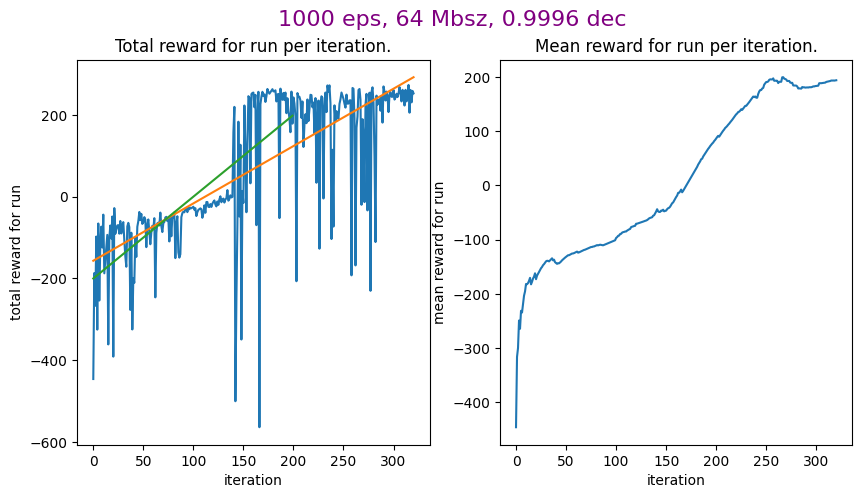

 33%|███▎      | 327/1000 [05:21<11:01,  1.02it/s, last 100 eps R avg=201, R=246, ε=0.01, mem sz=|████████████████■■■■| 26737/32000] 

Done training, it good enough d=====(￣▽￣*)b


In [4]:
memory = Memory(max_size=MEMORY_SIZE)
agent = Agent(
    network=QNetwork(DEVICE), 
    memory=memory, 
    optimizer=OPTIMIZER, 
    epsilon=START_EPSILON, 
    decay=DECAY, 
    n_actions=N_ACTIONS
)

if DOUBLE_AGENT:
    agent = DoubleAgent(
        network=QNetwork(DEVICE), 
        target_network=QNetwork(DEVICE), 
        memory=memory, 
        optimizer=OPTIMIZER, 
        epsilon=START_EPSILON, 
        decay=DECAY, 
        n_actions=N_ACTIONS,
        tau=TAU
    )

if os.path.exists(f"saved_models/after_{NUMBER_OF_EPISODES}-eps_{MEMORY_BATCH_SIZE_PER_TRAINING_STEP}-Mbsz_{DECAY}-dec{'_DQ' if DOUBLE_AGENT else '_Q'}"):
    output = input("You seem to have already trained this model before, want to train it again?\n\t[y]/n?")
    if output in ["yes", "Yes", 'y', 'Y', '']:
        train(agent)
    else:
        exit()
else:
    train(agent)

In [7]:
post_network = QNetwork(DEVICE)
post_network.load(f"saved_models/after_{NUMBER_OF_EPISODES}-eps_{MEMORY_BATCH_SIZE_PER_TRAINING_STEP}-Mbsz_{DECAY}-dec{'_DQ' if DOUBLE_AGENT else '_Q'}")

post_memory = Memory(max_size=MEMORY_SIZE)

post_agent = Agent(
    network=post_network, 
    memory=post_memory, 
    optimizer=OPTIMIZER, 
    epsilon=FINAL_EPSILON, 
    decay=DECAY,
    n_actions=N_ACTIONS
)

Using cpu device



In [8]:

env = gym.make("LunarLander-v2", render_mode="human")
print(post_agent.run(env))
env.close()

201.44028667785628
